In [ ]:
!pip install -q python-igraph joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 70.2 MB/s eta 0:00:0000:0100:01


In [11]:
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from joblib import Parallel, delayed

# --- 1. PARAMETRI GENERALI ---
N = 100000
M = 5
k_list = np.arange(2, 12)  # 10 valori: da 2 a 11
f_sim = np.linspace(0.0, 0.99, 100)  # Risoluzione alta per fittare bene
N_JOBS = -1  # usa tutti i core disponibili

# Funzione per il fit lineare S = A(b - f)
def linear_scaling(x, A, b):
    return A * (b - x)

# Funzione per fittare la curva dei f_c misurati vs k
def teoria_fc(k, c):
    # Idealmente c = 1, la lasciamo libera per verificare la convergenza ai dati
    return 1 - (c / k)

def simula_run(k, N, f_sim, seed):
    rng = np.random.default_rng(seed)
    p_prob = k / (N - 1)
    G = ig.Graph.Erdos_Renyi(n=N, p=p_prob, directed=False)

    nodi_shuffled = rng.permutation(N)
    S_run = np.zeros(len(f_sim))

    for j, f in enumerate(f_sim):
        N_keep = int(N * (1 - f))
        if N_keep > 0:
            sub_G = G.subgraph(nodi_shuffled[:N_keep])
            sizes = sub_G.connected_components().sizes()
            S_run[j] = max(sizes) / N if sizes else 0.0
        else:
            S_run[j] = 0.0

    return S_run

# Dizionari per salvare i risultati da plottare alla fine
S_norm_tutti = {}
S_std_tutti = {}
fc_misurati = []
fc_err = []

print(f"Avvio simulazione parallela per k da {k_list[0]} a {k_list[-1]} (N={N}, M={M}, n_jobs={N_JOBS})...")

# --- 2. CICLO SUI DIVERSI GRADI MEDI ---
for k in k_list:
    semi = [1000 * k + i for i in range(M)]
    S_runs_list = Parallel(n_jobs=N_JOBS, prefer='processes')(
        delayed(simula_run)(k, N, f_sim, seed) for seed in semi
    )
    S_results = np.array(S_runs_list)

    # Statistica e normalizzazione run-by-run: S(f)/S(0)
    S_norm_runs = np.divide(
        S_results,
        S_results[:, [0]],
        out=np.zeros_like(S_results),
        where=S_results[:, [0]] != 0
    )
    S_norm = np.mean(S_norm_runs, axis=0)
    S_std = np.std(S_norm_runs, axis=0, ddof=1) if M > 1 else np.zeros_like(S_norm)
    S_norm_tutti[k] = S_norm
    S_std_tutti[k] = S_std

    # --- FIT DINAMICO ---
    # Posizioniamo la maschera in base al valore teorico atteso per questo k
    fc_atteso = 1 - (1 / k)
    # Prendiamo una finestra poco prima del crollo, assicurandoci che S_norm sia sceso sotto 0.8
    # per evitare la zona piatta iniziale
    mask = (f_sim >= fc_atteso - 0.15) & (f_sim <= fc_atteso - 0.03) & (S_norm < 0.8)

    try:
        f_fit = f_sim[mask]
        S_fit = S_norm[mask]

        popt, pcov = curve_fit(linear_scaling, f_fit, S_fit, p0=[2.0, fc_atteso])
        fc_misurato = popt[1]
        err = np.sqrt(pcov[1, 1])
    except:
        # Fallback nel caso in cui la finestra non raccolga dati validi
        fc_misurato = np.nan
        err = np.nan

    fc_misurati.append(fc_misurato)
    fc_err.append(err)
    print(f"k = {k:2d} | fc teorico: {fc_atteso:.3f} | fc misurato: {fc_misurato:.3f}")

# Convertiamo in array per comodità
fc_misurati = np.array(fc_misurati)
fc_err = np.array(fc_err)


Avvio simulazione parallela per k da 2 a 11 (N=100000, M=5, n_jobs=-1)...
k =  2 | fc teorico: 0.500 | fc misurato: 0.503
k =  3 | fc teorico: 0.667 | fc misurato: 0.669
k =  4 | fc teorico: 0.750 | fc misurato: 0.758
k =  5 | fc teorico: 0.800 | fc misurato: 0.810
k =  6 | fc teorico: 0.833 | fc misurato: 0.842
k =  7 | fc teorico: 0.857 | fc misurato: 0.871
k =  8 | fc teorico: 0.875 | fc misurato: 0.888
k =  9 | fc teorico: 0.889 | fc misurato: 0.902
k = 10 | fc teorico: 0.900 | fc misurato: 0.913
k = 11 | fc teorico: 0.909 | fc misurato: 0.924


Chi-quadro ridotto del fit finale: 63.0963


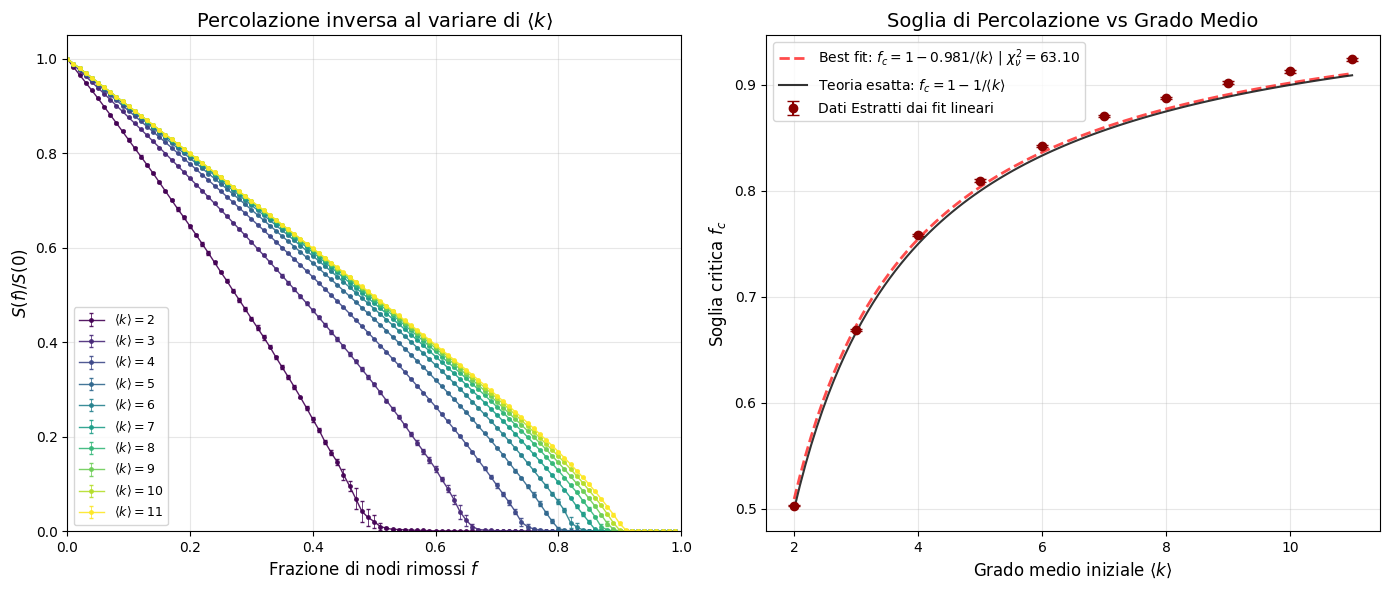

In [12]:
# --- 3. GRAFICI ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# GRAFICO 1: Tutte le curve S(f)/S(0) con incertezza (deviazione standard)
colormap = plt.cm.viridis(np.linspace(0, 1, len(k_list)))
for idx, k in enumerate(k_list):
    ax1.errorbar(
        f_sim,
        S_norm_tutti[k],
        yerr=S_std_tutti[k],
        fmt='-o',
        markersize=2.5,
        linewidth=1.0,
        elinewidth=0.6,
        capsize=1.5,
        color=colormap[idx],
        alpha=0.9,
        label=f'$\\langle k \\rangle = {k}$'
    )

ax1.set_xlabel('Frazione di nodi rimossi $f$', fontsize=12)
ax1.set_ylabel('$S(f) / S(0)$', fontsize=12)
ax1.set_title('Percolazione inversa al variare di $\\langle k \\rangle$', fontsize=14)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1.05)
ax1.legend(loc='lower left', fontsize=9)
ax1.grid(True, alpha=0.3)

# GRAFICO 2: Soglia critica in funzione di k
# Fit dei punti misurati con la forma f_c = 1 - c/k
valid_mask = np.isfinite(fc_misurati) & np.isfinite(fc_err) & (fc_err > 0)
k_valid = k_list[valid_mask]
fc_valid = fc_misurati[valid_mask]
err_valid = fc_err[valid_mask]

if len(k_valid) >= 2:
    popt_k, _ = curve_fit(teoria_fc, k_valid, fc_valid, sigma=err_valid, absolute_sigma=True)
    c_opt = popt_k[0]

    residui = fc_valid - teoria_fc(k_valid, c_opt)
    chi2 = np.sum((residui / err_valid) ** 2)
    dof = len(k_valid) - 1  # numero parametri del fit = 1 (solo c)
    chi2_ridotto = chi2 / dof if dof > 0 else np.nan
else:
    c_opt = np.nan
    chi2_ridotto = np.nan

# Disegno punti misurati
ax2.errorbar(k_list, fc_misurati, yerr=fc_err, fmt='o', markersize=6, 
             color='darkred', label='Dati Estratti dai fit lineari', capsize=4)

# Curva di best fit
k_smooth = np.linspace(k_list[0], k_list[-1], 100)
if np.isfinite(c_opt):
    ax2.plot(k_smooth, teoria_fc(k_smooth, c_opt), 'r--', lw=2, alpha=0.7,
             label=f'Best fit: $f_c = 1 - {c_opt:.3f}/\\langle k \\rangle$ | $\\chi^2_\\nu = {chi2_ridotto:.2f}$')

# Curva teorica esatta (Molloy-Reed)
ax2.plot(k_smooth, 1 - 1/k_smooth, 'k-', lw=1.5, alpha=0.8,
         label='Teoria esatta: $f_c = 1 - 1/\\langle k \\rangle$')

ax2.set_xlabel('Grado medio iniziale $\\langle k \\rangle$', fontsize=12)
ax2.set_ylabel('Soglia critica $f_c$', fontsize=12)
ax2.set_title('Soglia di Percolazione vs Grado Medio', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

print(f"Chi-quadro ridotto del fit finale: {chi2_ridotto:.4f}")

plt.tight_layout()
plt.show()